In [1]:
import json
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
import simplesimdb as simplesim # this one is our own database manager
import subprocess # to capture errors from the simulations
import common
import pandas as pd

In [2]:
m = simplesim.Manager( directory = 'vmax', filetype = 'nc')

In [3]:
help(simplesim.Manager
)

Help on class Manager in module simplesimdb:

class Manager(builtins.object)
 |  Manager(directory='./data', filetype='nc', executable='./execute.sh')
 |  
 |  Lightweight Simulation Database Manager
 |  
 |  Create, access and display simulation data of a given code as pairs
 |  (inputfile.json : outputfile [, restarted_01, restarted_02, ...]),
 |  where all input is given by python dictionaries (stored as json files)
 |  and the output files (of arbitrary type) are generated by an executable
 |  that takes the json file as input. This executable is provided by the user.
 |  
 |  NOTE: an executable may only take one sinlge input file and may only
 |      generate one single output file (except for RESTART, see below)
 |  NOTE: the executable can be a bash script. For example if the actual program
 |      does not take json input files you could write a converter and let the bash
 |      script chain the two programs. There are endless possibilities.
 |  
 |  RESTART ADDON (ignore if 

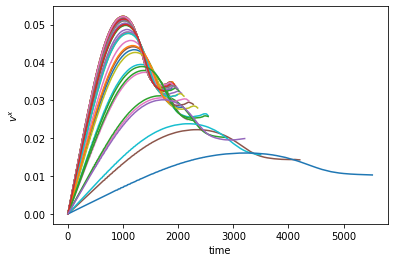

In [4]:
aj_v = []
muj_v = []
vmax_v = []
vana_v = []
for item in m.table() :
    ncin = Dataset( m.outfile( item), 'r', format="NETCDF4")
    pp = json.loads( ncin.inputfile)
    diag_time = ncin["diag_time"][:]
    com_e = ncin["X_e"][:]
    vel_e = common.centered_derivative( diag_time, com_e)
    vel_e[0] = 0
    aj = pp['species'][2]['a']
    muj = pp['species'][2]['mu']
    plt.plot( diag_time, vel_e, label = f'aj = "{aj}", mu_j = "{muj}"' )
    aj_v.append( aj)
    muj_v.append( muj)
    vmax_v.append( max(vel_e))
    vana_v.append( np.sqrt( pp['species'][1]['init']['amplitude']*
                           pp['species'][1]['init']['sigma']*pp['curvature']*
                           (1 + pp['species'][1]['a']*pp['species'][1]['tau']
                              + pp['species'][2]['a']*pp['species'][2]['tau'])/
                          (pp['species'][1]['a']*pp['species'][1]['mu']+
                            pp['species'][2]['a']*pp['species'][2]['mu']) )
    )
plt.xlabel('time')
plt.ylabel(r'$v^x$')
plt.show()

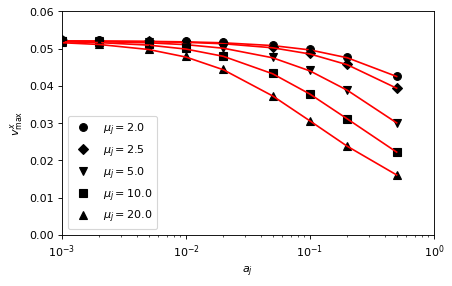

In [5]:
df = pd.DataFrame(
    {'aj': aj_v,
     'muj': muj_v,
     'vmax': vmax_v,
     'vana' : vana_v
    })
markers = ["o", "D","v","s","^"]
i = 0
df.sort_values( by = ['muj', 'aj'], inplace = True)
fig,ax=plt.subplots(1,1,figsize=(6,3.7),dpi= 80, facecolor='w', edgecolor='k')
for first, second in df.groupby( 'muj'):
    ax.plot( second['aj'], second['vmax'], marker=markers[i], markersize = 7, ls = '',
            color='k', label = r"$\mu_j=%.1f$"%first)
    ax.plot( second['aj'], 0.77*second['vana'], color = 'r')
    i += 1
ax.set_xscale('log')
ax.legend()
ax.set_xlabel( r'$a_j$')
ax.set_ylabel( r'$v^x_\max}$')
ax.set_xlim(1e-3,1)
ax.set_ylim(0,0.06)
plt.show()

mu_j = 5, a_j = 0.5, Time =  2994.706819685768


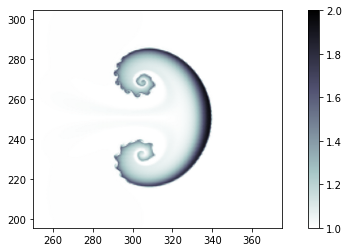

mu_j = 2, a_j = 0.001, Time =  1729.859069867477


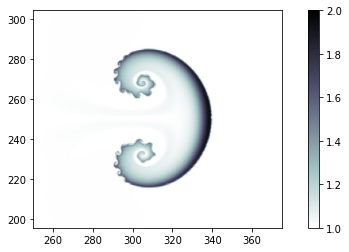

In [6]:
## Figure 3
# muj = 5, aj = 0.5 vs muj = 2, aj = 0.001 
for item in m.table():
    if item['species'][2]['mu'] == 5 and item['species'][2]['a'] == 0.5 :
        firstfile = m.outfile( item)
    if item['species'][2]['mu'] == 2 and item['species'][2]['a'] == 0.001 :
        secondfile = m.outfile( item)

ncin = Dataset( firstfile, 'r', format="NETCDF4")
xfi = 512
xli = 1024-256
yfi = 400
yli = 1024-yfi
x = ncin["x"][xfi:xli]
y = ncin["y"][yfi:yli]
vo = ncin["n_e"][-1,yfi:yli,xfi:xli]
time = ncin["time"][:]
plt.figure(figsize=(6, 4))
plt.pcolormesh(x,y,vo,
               shading='gouraud',
               cmap = 'bone_r', vmin = 1.0, vmax = 2 )
print( "mu_j = 5, a_j = 0.5, Time = ", time[-1])
plt.colorbar()
plt.axis('scaled')
plt.show()
ncin.close()
ncin = Dataset( secondfile, 'r', format="NETCDF4")
vo = ncin["n_e"][-2,yfi:yli,xfi:xli]
time = ncin["time"][:]
plt.figure(figsize=(6, 4))
plt.pcolormesh(x,y,vo,
               shading='gouraud',
               cmap = 'bone_r', vmin = 1.0, vmax = 2)
print( "mu_j = 2, a_j = 0.001, Time = ", time[-2])
plt.colorbar()
plt.axis('scaled')
plt.show()

In [7]:
m = simplesim.Manager( directory = 'caseA', filetype = 'nc')

mu_j = 2, a_j = 0.01, Time =  222.93652636714424


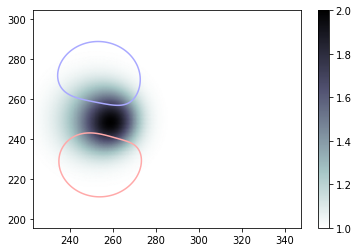

mu_j = 2, a_j = 0.01, Time =  557.3413159178606


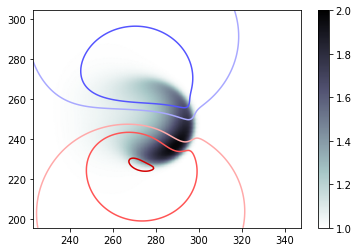

mu_j = 2, a_j = 0.01, Time =  891.746105468577


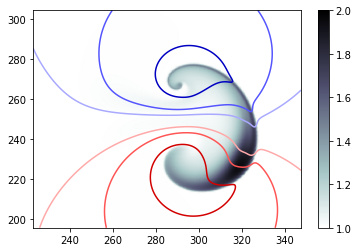

In [8]:
## Figure 4
# muj = 2, aj = 0.01 
for item in m.table():
    if item['species'][2]['mu'] == 2 and item['species'][2]['a'] == 0.01 \
    and item['species'][2]['tau'] == 2:
        outfile = m.outfile( item)

ncin = Dataset( outfile, 'r', format="NETCDF4")
xfi = 256+200
xli = 1024-512+200
yfi = 400
yli = 1024-yfi
for idx in [2,5,8] :
    x = ncin["x"][xfi:xli]
    y = ncin["y"][yfi:yli]
    vo = ncin["n_e"][idx,yfi:yli,xfi:xli]
    time = ncin["time"][:]
    plt.figure(figsize=(6, 4))
    plt.pcolormesh(x,y,vo,
                   shading='gouraud',
                   cmap = 'bone_r', vmin = 1.0, vmax = 2 )
    plt.colorbar()
    xc = ncin["xc"][yfi:yli,xfi:xli]
    yc = ncin["yc"][yfi:yli,xfi:xli]
    vo = ncin["psi_e"][idx,yfi:yli,xfi:xli]
    plt.contour( xc, yc, vo, levels = [-2,-1,-0.5,0.5,1,2],
                cmap = 'seismic',vmin=-3, vmax=3) # range is [-3,3] approx
    print( "mu_j = 2, a_j = 0.01, Time = ", time[idx])
    plt.show()


aj = 0.1, muj = 5, Time =  679.5528215557482


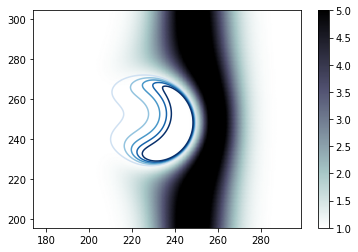

aj = 0.1, muj = 5, Time =  1087.2845144891971


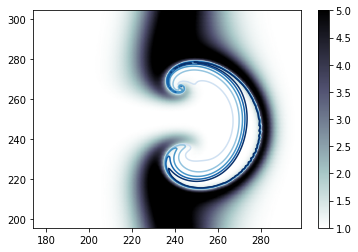

In [9]:
outfile = m.outfile(m.table()[0])
ncin = Dataset( outfile, 'r', format="NETCDF4")
xfi = 256+100
xli = 1024-512+100
yfi = 400
yli = 1024-yfi
for idx in [5,8] :
    xc = ncin["xc"][yfi:yli,xfi:xli]
    yc = ncin["yc"][yfi:yli,xfi:xli]
    ni = ncin["n_i"][idx,yfi:yli,xfi:xli]
    nj = ncin['n_j'][idx,yfi:yli,xfi:xli]
    time = ncin["time"][:]
    plt.figure(figsize=(6, 4))
    plt.pcolormesh(xc,yc,nj,
                   shading='gouraud',
                   cmap = 'bone_r', vmin = 1.0, vmax = 5 )
    plt.colorbar()
    plt.contour( xc, yc, ni, levels = [1.1,1.2,1.3,1.4,1.5],
                cmap = 'Blues',vmin=1, vmax=1.5) # range is [-3,3] approx
    
    print( "aj = 0.1, muj = 5, Time = ", time[idx])
    plt.show()

In [10]:
m = simplesim.Manager( directory = 'caseB', filetype = 'nc')

aj = 0.1, muj = 5, Time =  1136.5412348075374


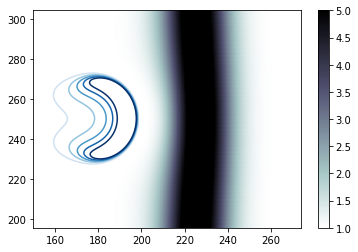

aj = 0.1, muj = 5, Time =  2045.7742226535674


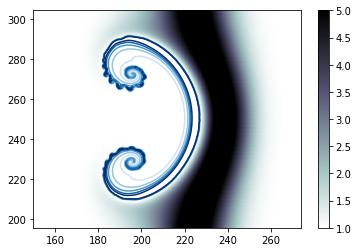

In [11]:
outfile = m.outfile(m.table()[0])
ncin = Dataset( outfile, 'r', format="NETCDF4")
xfi = 256+50
xli = 1024-512+50
yfi = 400
yli = 1024-yfi
for idx in [5,9] :
    xc = ncin["xc"][yfi:yli,xfi:xli]
    yc = ncin["yc"][yfi:yli,xfi:xli]
    ni = ncin["n_i"][idx,yfi:yli,xfi:xli]
    nj = ncin['n_j'][idx,yfi:yli,xfi:xli]
    time = ncin["time"][:]
    plt.figure(figsize=(6, 4))
    plt.pcolormesh(xc,yc,nj,
                   shading='gouraud',
                   cmap = 'bone_r', vmin = 1.0, vmax = 5 )
    plt.colorbar()
    plt.contour( xc, yc, ni, levels = [1.1,1.2,1.3,1.4,1.5],
                cmap = 'Blues',vmin=1, vmax=1.5) # range is [-3,3] approx
    
    print( "aj = 0.1, muj = 5, Time = ", time[idx])
    plt.show()

Vmax is 0.0032840673937233654


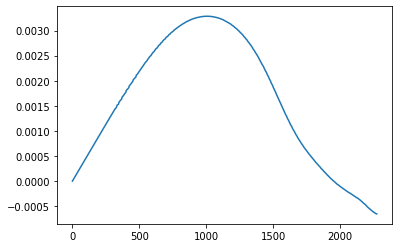

In [12]:
diag_time = ncin["diag_time"][:]
com_e = ncin["X_e"][:]
vel_e = common.centered_derivative( diag_time, com_e)
vel_e[0] = 0
aj = pp['species'][2]['a']
muj = pp['species'][2]['mu']
plt.plot( diag_time, vel_e, label = f'aj = "{aj}", mu_j = "{muj}"' )
print( "Vmax is", max(vel_e))
plt.show()

This does not seem to be the max velocity from the paper

In [13]:
# Figure 6
m = simplesim.Manager( directory = 'caseC', filetype = 'nc')

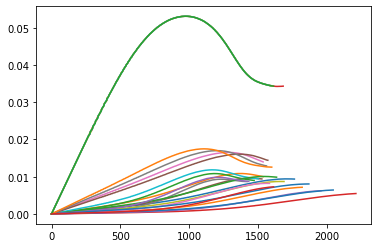

In [14]:
aj_v = []
muj_v = []
vmax_v = []
for item in m.table() :
    ncin = Dataset( m.outfile( item), 'r', format="NETCDF4")
    pp = json.loads( ncin.inputfile)
    diag_time = ncin["diag_time"][:]
    com_e = ncin["X_e"][:]
    vel_e = common.centered_derivative( diag_time, com_e)
    vel_e[0] = 0
    aj = pp['species'][2]['a']
    muj = pp['species'][2]['mu']
    plt.plot( diag_time, vel_e, label = f'aj = "{aj}", mu_j = "{muj}"' )
    aj_v.append( aj)
    muj_v.append( muj)
    vmax_v.append( max(vel_e))

Some simulations crashed and max V has not been reached so should be resimulated

{0.075, 0.1, 0.2, 0.15, 0.03, 0}


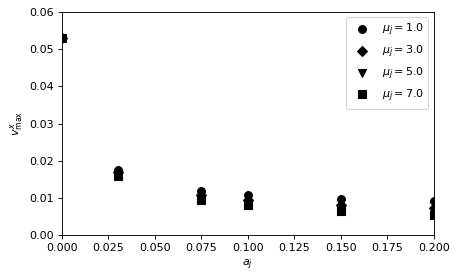

In [15]:
df = pd.DataFrame(
    {'aj': aj_v,
     'muj': muj_v,
     'vmax': vmax_v
    })
markers = ["o", "D","v","s"]
i = 0
df.sort_values( by = ['muj', 'aj'], inplace = True)
fig,ax=plt.subplots(1,1,figsize=(6,3.7),dpi= 80, facecolor='w', edgecolor='k')
for first, second in df.groupby( 'muj'):
    ax.plot( second['aj'], second['vmax'], marker=markers[i], markersize = 7, ls = '',
            color='k', label = r"$\mu_j=%.1f$"%first)
    i += 1
# ax.set_xscale('log')
ax.legend()
ax.set_xlabel( r'$a_j$')
ax.set_ylabel( r'$v^x_\max}$')
ax.set_xlim(0,0.2)
ax.set_ylim(0,0.06)
print(set(aj_v))
plt.show()

caseB/0e8b671bc1db71e3352439ecfb3ffac08e9cd91c.nc
CASE caseB
mu_j = 2, a_j = 0.01, Time =  1136.5412348075374


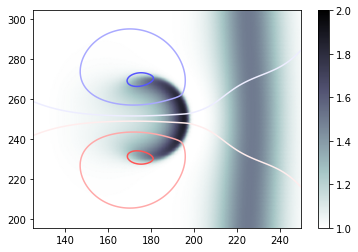

mu_j = 2, a_j = 0.01, Time =  1591.1577287305524


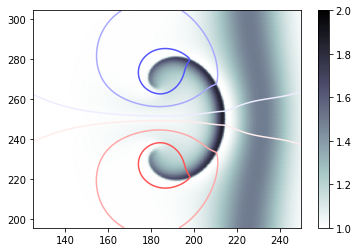

caseC/4cf82467f486e7972c339749ed64562905304c93.nc
CASE caseC
mu_j = 2, a_j = 0.01, Time =  1136.5412348075374


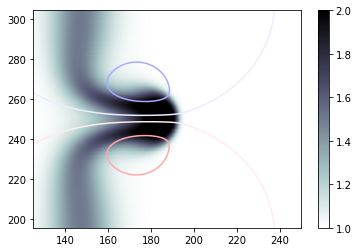

mu_j = 2, a_j = 0.01, Time =  1591.1577287305524


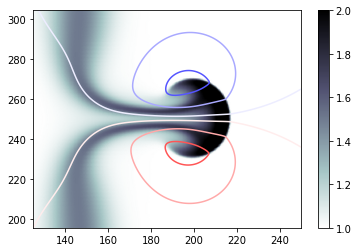

In [16]:
## New analogous Figure 4
for file in ['caseB', 'caseC']:
    m = simplesim.Manager( directory = file, filetype = 'nc')
    # muj = 5, aj = 0.1 
    for item in m.table():
        if item['species'][2]['mu'] == 5 and item['species'][2]['a'] == 0.1 :
            outfile = m.outfile( item)
            print( outfile)
    print( 'CASE', file)
    ncin = Dataset( outfile, 'r', format="NETCDF4")
    xfi = 256
    xli = 1024-512
    yfi = 400
    yli = 1024-yfi
    for idx in [5,7] :
        x = ncin["x"][xfi:xli]
        y = ncin["y"][yfi:yli]
        vo = ncin["n_e"][idx,yfi:yli,xfi:xli]
        time = ncin["time"][:]
        plt.figure(figsize=(6, 4))
        plt.pcolormesh(x,y,vo,
                       shading='gouraud',
                       cmap = 'bone_r', vmin = 1.0, vmax = 2 )
        plt.colorbar()
        xc = ncin["xc"][yfi:yli,xfi:xli]
        yc = ncin["yc"][yfi:yli,xfi:xli]
        vo = ncin["psi_e"][idx,yfi:yli,xfi:xli]
        plt.contour( xc, yc, vo, levels = [-2,-1,-0.5, -0.1, 0.1,0.5,1,2],
                    cmap = 'seismic',vmin=-3, vmax=3) # range is [-3,3] approx
        print( "mu_j = 2, a_j = 0.01, Time = ", time[idx])
        plt.show()
    ncin.close()

caseB/0e8b671bc1db71e3352439ecfb3ffac08e9cd91c.nc
CASE caseB
caseC/4cf82467f486e7972c339749ed64562905304c93.nc
CASE caseC


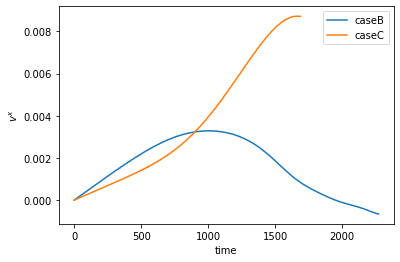

In [17]:
## New analogous Figure 4
for file in ['caseB', 'caseC']:
    m = simplesim.Manager( directory = file, filetype = 'nc')
    # muj = 5, aj = 0.1 
    for item in m.table():
        if item['species'][2]['mu'] == 5 and item['species'][2]['a'] == 0.1 :
            outfile = m.outfile( item)
            print( outfile)
    print( 'CASE', file)
    ncin = Dataset( outfile, 'r', format="NETCDF4")
    diag_time = ncin["diag_time"][:]
    com_e = ncin["X_e"][:]
    vel_e = common.centered_derivative( diag_time, com_e)
    vel_e[0] = 0
    plt.plot( diag_time, vel_e, label = file )
plt.xlabel( 'time')
plt.ylabel( r'$v^x$')
plt.legend()
plt.show()